### Submission by: Haemanth Velmurugan

### Task 2: Odd to Even

Design a quantum algorithm that when given numbers of range [1,n) and are odd convert them into even numbers, and they must stay in the same range so they cannot be less than 1 nor greater than n. n = 2^k where k is the number of qubits you are going to use.

**Example:**

B = odd_to_even(n = 31, list= [1,2,2,4,5,6,7,11,17,21,22,23]) <br>
print(B)

One possible output is
[2,2,2,4,4,6,8,10,18,20,22,22]

Exist multiple solutions.

**References:**

[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558. <br><br>
[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.<br><br>
[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), arXiv:quant-ph/9605043

### Approach:

We encode the list as QRAM following the $|index\rangle|value\rangle$ format. We use 1 ancilla to identify odd values. This can be easily done by copying the LSB's value to the ancilla (using a $CNOT$ gate on ancilla controlled by the LSB). 

If ancilla is $1$ (which means $1^{st}$ bit is $0$ and hence number is odd), simply toggle $1^{st}$ bit. So every $odd\_value$ becomes $odd\_value - 1$, which is even and will never be greater than $n$. However, $1$ becomes $0$. In order to tackle this we use another ancilla to mark the value $0$. If ancilla is marked, we simply toggle the $2^{nd}$ bit (hence we store $2$ in place of $0$, which was originally $1$) 

In [24]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer
from qiskit.circuit.library import XGate
from qiskit.visualization import plot_histogram
import numpy as np

In [3]:
def get_size_bin(num):
    '''
    num - A positive integer 
    
    Returns the number of bits needed to represent the number num in binary
    '''
    return int(np.log2(num)) + 1   

def encode_as_QRAM(num_list, index_len, data_len):
    '''
    num_list - List of numbers (array) to be encoded
    index_len - number of bits needed to represent indices
                Also the length of the index register that stores the indices of the elements in the array 
    data_len - number of bits needed to represent the values (data) in the array
               Also the length of the value (data) register that stores the elements in the array
    
    Returns a quantum circuit encoding the data num_list in the form |index>|value>
    '''
    # Define the quantum registers and the circuit
    index_reg = QuantumRegister(index_len)
    data_reg = QuantumRegister(data_len)
    qc = QuantumCircuit(index_reg, data_reg)
    
    # start with an equal superposition of all indices
    qc.h(index_reg)
    
    mcnot = XGate().control(index_len)  
    # The multi-controlled NOT gate to entangle indices and their corresponding array data
    
    for idx, data in enumerate(num_list):
        
        bin_idx = format(idx, f'0{index_len}b')  # convert index (integer) to binary
        
        idx_0_bits = [i for i, digit in enumerate(reversed(bin_idx)) if digit == '0']  # find all the 0 bits in index (binary) 
        ### if index bit is 0, we apply an X gate followed by the traditional CNOT gate which is controlled by the value 1
        ### Applying X gates to these indices before CNOT, would result in a 0-value-controlled CNOT.
        
        control_0 = False  # flag indicating whether any X gates are needed before the CNOT
        
        # retrieve the index qubits (control qubits) which will be zero-valued controls in the multi-controlled-NOT gate
        if len(idx_0_bits) > 0:
            control_0_bits = index_reg[idx_0_bits]
            control_0 = True
        
        bin_data = format(data, f'0{data_len}b')        
        data_set_bits = [i for i, digit in enumerate(reversed(bin_data)) if digit == '1']
        # we need to set only these bits in the data register for the current index 
        
        if control_0:
            qc.x(control_0_bits)   # transform 0-valued controls into 1-valued controls by applying X gate
            
        for bit in data_set_bits:
            qc.append(mcnot, index_reg[:] + [data_reg[bit]])  
            # encode the data value by setting the required bits to 1 controlled by the current index value 
            # (establishing entanglement between the index and value)
        
        if control_0:
            qc.x(control_0_bits)   # undo the X gates applied to use 0-valued control qubits
            
    return qc

In [79]:
def odd_to_even_in_range(n, nums):
    '''
    n: upper limit for the range of values that are allowed
    nums: list of numbers in range [1,n)
    
    Returns a quantum circuit that converts all odd values in nums to even values in the range [1,n)
    '''
    
    data_len = get_size_bin(n)
    index_len = get_size_bin(len(nums))
    
    index_qreg = QuantumRegister(index_len)
    data_qreg = QuantumRegister(data_len)
    ancilla = QuantumRegister(2)
    index_creg = ClassicalRegister(index_len)
    data_creg = ClassicalRegister(data_len)
    qc = QuantumCircuit(index_qreg, data_qreg, ancilla, index_creg, data_creg)
    
    encoder = encode_as_QRAM(nums, index_len, data_len)
    
    qc.append(encoder, index_qreg[:] + data_qreg[:])
    
    # copy LSB to ancilla and reset LSB - now value becomes value-1 for all odd values and is always less than n
    qc.cnot(data_qreg[0], ancilla[0])
    qc.cnot(ancilla[0], data_qreg[0])
    
    # Handling the 0 case
    mcnot = XGate().control(data_len)
    
    # mark another ancilla if all data bits are 0 and simply toggle the second bit if this ancilla is set 
    # (we now store the value 2 in place of 0)
    qc.x(data_qreg)
    qc.append(mcnot, data_qreg[:] + ancilla[1:])
    qc.x(data_qreg)
    
    qc.cnot(ancilla[1], data_qreg[1])

    qc.barrier()
    
    qc.measure(index_qreg, index_creg)
    qc.measure(data_qreg, data_creg)
    
    return qc

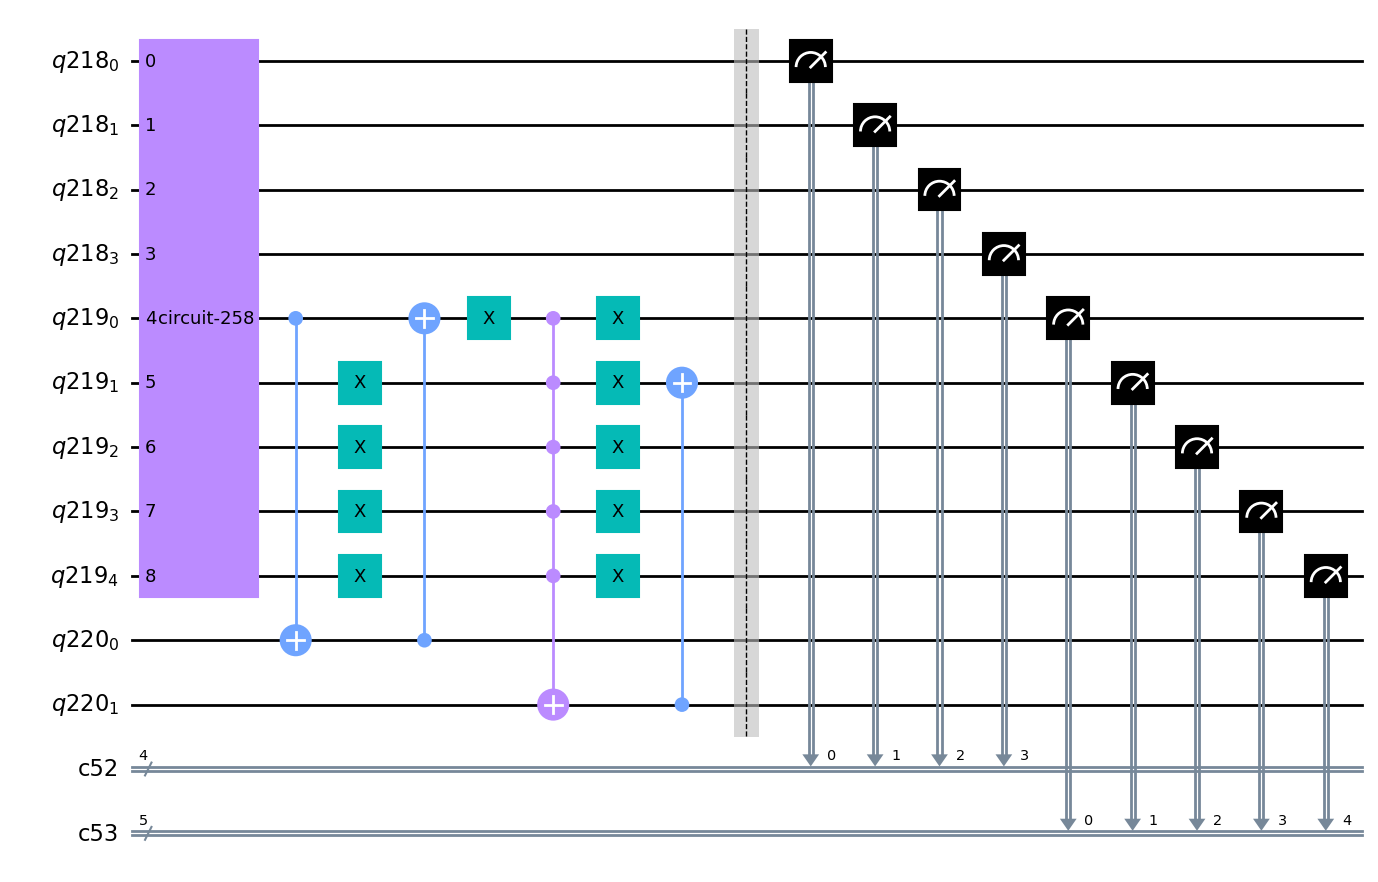

In [80]:
qc = odd_to_even_in_range(31, [1,2,2,4,5,6,7,11,17,21,22,23])
qc.draw('mpl')

In [71]:
def execute_circ(qc):
    '''
    qc - quantum circuit to run on qasm simulator
    
    Returns the circuit measurement outcomes over 1024 shots
    '''
    job = execute(qc, Aer.get_backend('qasm_simulator'), shots=1024)
    counts = job.result().get_counts(qc)
    return counts

In [72]:
def get_results(n, nums):
    
    qc = odd_to_even_in_range(n, nums)
    counts = execute_circ(qc)
    
    new_list = [0 for i in range(len(nums))]
    
    for key in counts:
        key_split = key.split()
        idx = int(key_split[1], 2)
        val = int(key_split[0], 2)
        
        if idx > len(nums)-1:
            continue
        
        new_list[idx] = val
        
    return new_list

In [81]:
output = get_results(31, [1,2,2,4,5,6,7,11,17,21,22,23])
output

[2, 2, 2, 4, 4, 6, 6, 10, 16, 20, 22, 22]